In [ ]:
from google.colab.files import upload
from google.colab import files
uploaded = files.upload()


Saving my_model.h5 to my_model (1).h5


In [ ]:
from tensorflow.keras.models import load_model
import pandas as pd
model = load_model('/content/my_model .h5')


In [ ]:
pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 45.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 79.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 53.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 24.9 MB/s eta 0:00:00


In [ ]:
import json
import pandas as pd

# Load data
with open('authentic_nft_data.json', 'r') as file:
    authentic_nft_data = json.load(file)
with open('fake_nft.json', 'r') as file:
    fake_nft_data = json.load(file)

# Convert to DataFrame
authentic_nft_df = pd.DataFrame(authentic_nft_data)
fake_nft_df = pd.DataFrame(fake_nft_data)

# Expand nested columns and label the data
authentic_nft_expanded = pd.json_normalize(authentic_nft_df['result'])
fake_nft_expanded = pd.json_normalize(fake_nft_df['result'])
authentic_nft_expanded['label'] = 1
fake_nft_expanded['label'] = 0

# Combine and fill missing values
combined_nft_data = pd.concat([authentic_nft_expanded, fake_nft_expanded], ignore_index=True)
combined_nft_data.fillna({
    'name': 'Unknown',
    'description': 'Unknown',
    'royalty': 0,
    'symbol': 'Unknown',
    'primary_sale_happened': False,
    'collection.verified': False,
    'owner': 'Unknown'
}, inplace=True)

In [ ]:
from transformers import BertTokenizer, BertModel
import torch

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

def encode_with_bert(text):
    inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt", max_length=128)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
# Split the data to create a new test set
_, new_test_data = train_test_split(combined_nft_data, test_size=0.1, random_state=42)


In [ ]:
# Extract BERT-encoded features for the new test set's names and descriptions
encoded_names_test = np.array([encode_with_bert(name) for name in new_test_data['name']])
encoded_descriptions_test = np.array([encode_with_bert(desc) for desc in new_test_data['description']])

# Stack the encoded names and descriptions together
X_new_test = np.hstack([encoded_names_test, encoded_descriptions_test])

# Reshape the data to fit the CNN model's expected input shape
X_new_test_reshaped = X_new_test.reshape(-1, 128, 12)

# Extract labels for the new test set
y_new_test = new_test_data['label'].values

16/16 [==============================] - 0s 9ms/step
New Test Loss: 0.006108426488935947
New Test Accuracy: 0.9980040192604065
F1 Score on New Test Data: 0.9977011494252873
Precision on New Test Data: 0.9954128440366973
Recall on New Test Data: 1.0


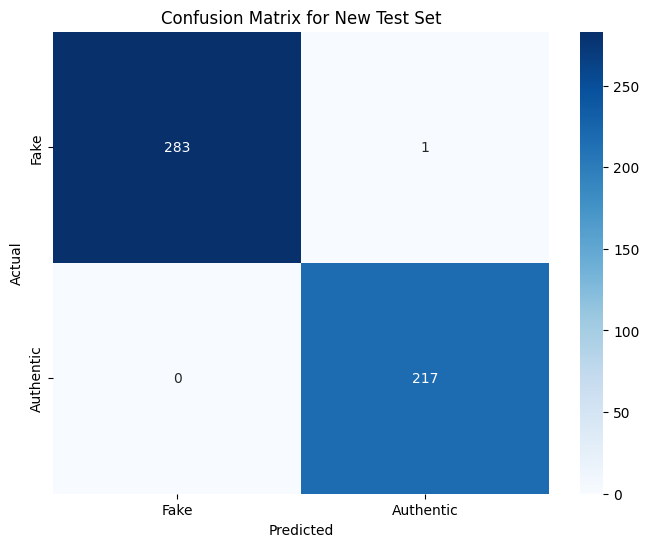

In [ ]:
import json
import pandas as pd
from transformers import BertTokenizer, BertModel
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
# Load the saved model
# Evaluate the model on the new test set
loss, accuracy = model.evaluate(X_new_test_reshaped, y_new_test)
y_pred_new = model.predict(X_new_test_reshaped)
y_pred_binary_new = (y_pred_new > 0.5).astype(int)  # Convert probabilities to binary output

# Calculate metrics
conf_matrix_new = confusion_matrix(y_new_test, y_pred_binary_new)
f1_new = f1_score(y_new_test, y_pred_binary_new)
precision_new = precision_score(y_new_test, y_pred_binary_new)
recall_new = recall_score(y_new_test, y_pred_binary_new)

# Print results
print(f"New Test Loss: {loss}")
print(f"New Test Accuracy: {accuracy}")
print(f"F1 Score on New Test Data: {f1_new}")
print(f"Precision on New Test Data: {precision_new}")
print(f"Recall on New Test Data: {recall_new}")

# Optional: Plot the confusion matrix for the new test set
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_new, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Authentic'], yticklabels=['Fake', 'Authentic'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for New Test Set')
plt.show()